In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### <font size=5>用pandas读取文件</font>

#### <font size=4>定义的一些读取文件，设置列标题，处理数据的方法（黑盒，直接调用就好）</font>

In [7]:
def get_dataset(path="./1.txt", header=False):
    """
    获取数据集，可选择是否为数据集添加列标题
    :param path: 文件路径
    :param header: True -> 添加列标题；False -> 不添加列标题
    :return: 数据集
    """
    dataset = pd.read_table(path, sep="\s+", skiprows=[0, 1], header=None)
    if header:
        # 添加列标题
        try:
            dataset.columns = list(pd.read_csv(path, sep="\s+", nrows=0))
        except Exception as e:
            dataset.columns = get_headers(path)

    return dataset

In [6]:
def get_headers(path):
    """
    获取数据集的列名称   ["x", "y", "z", "kxRe", "kxIm", "kyRe", "kyIm", "kzRe", "kzIm", "Area"]
    :param path: 文件路径
    :return: 包含所有列标题的列表
    """
    # 读取文件第一行内容的字符串形式
    header = list(pd.read_csv(path, nrows=0))[0]
    # 去掉所有空格
    header = header.replace(' ', '')
    # 初始化一个存储列标题的列表
    col = []

    # 用']'来划分列标题
    while header.find(']') != -1:
        i = header.find('[')
        j = header.find(']')
        # 去掉原始数据的单位
        col.append(header[:i])
        header = header[j + 1:]

    # 判断原字符串是否为空 or 纯空格
    if len(header) > 0 and not header.isspace():
        col.append(header)

    return col

#### <font size=4>用自定义方法读取文件数据</font>

<font size=3>读取4层曲面的数据：每一行表示一个点，前三列为该点的x、y、z三维坐标</font>

In [14]:
path = './2.txt'
data = get_dataset(path, True)
data = data.iloc[:, :3]
data                   # (n, 3)

,x,y,z
0,-379.864,-17.78270,217.3760
1,-379.864,-12.57440,217.3760
2,-382.091,-7.36607,218.5410
3,-371.615,-10.41670,212.7600
4,-374.626,-5.20833,214.4850
...,...,...,...
111268,-404.687,-1956.93000,-53.7173
111269,-404.687,-1971.11000,-53.7173
111270,-409.374,-1980.54000,-53.7863
111271,-418.748,-1985.25000,-53.9243


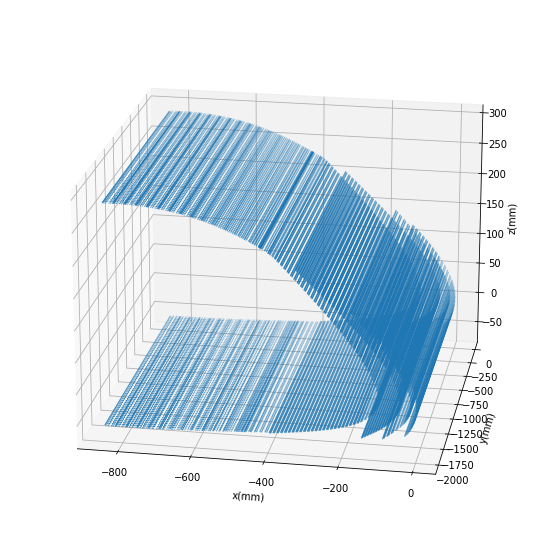

In [15]:
# 画三维图
plt.figure(figsize=(12, 10))
ax = plt.subplot(111, projection="3d")
ax.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], s=0.1)

ax.set_xlabel('x(mm)'), ax.set_ylabel('y(mm)'), ax.set_zlabel('z(mm)')
ax.view_init(20, -80)

(Text(0.5, 0, 'x(mm)'), Text(0, 0.5, 'z(mm)'))

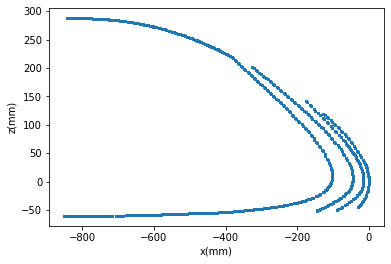

In [20]:
# 二维显示4层曲面：投影到xoz面实质上是4条曲线
ax = plt.subplot(111)
ax.scatter(data.iloc[:, 0], data.iloc[:, 2], s=1)
ax.set_xlabel('x(mm)'), ax.set_ylabel('z(mm)')

<font size=3>分析：想实现4个曲面的分类，可以简化为将上面4条曲线分类出来（去掉所有点的y轴数据，相当于对数据集作降维）</font>

#### <font size=4>去掉数据的y轴信息（降维）</font>

In [19]:
# 将三维坐标数据集降维
data1 = data.copy()
# 去掉第二列：y轴坐标
data1 = data1.drop(labels='y', axis=1)
# 将重复的（x, z）去掉
data1 = data1.drop_duplicates()
data1

,x,z
0,-379.864,217.3760
2,-382.091,218.5410
3,-371.615,212.7600
4,-374.626,214.4850
5,-362.584,207.5810
...,...,...
110908,-588.983,-57.6954
110909,-596.716,-57.8573
110910,-613.940,-58.1911
110911,-604.566,-58.0068


(Text(0.5, 0, 'x(mm)'), Text(0, 0.5, 'z(mm)'))

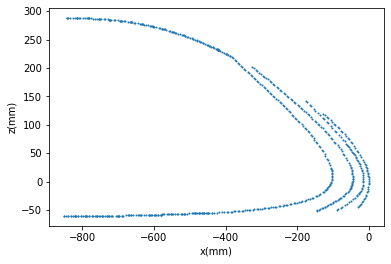

In [21]:
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=1)
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')

### <font size=5>聚类算法模型</font>

<font size=3>由图可知，4条曲线需要分4类，训练集为data1</font>

In [22]:
from sklearn.cluster import AgglomerativeClustering, KMeans

#### <font size=4>直接设置n_cluster=4，用kmeans和Agg算法查看效果</font>

##### <font size=3>kmeans分类效果</font>

Text(0.5, 1.0, 'kmeans')

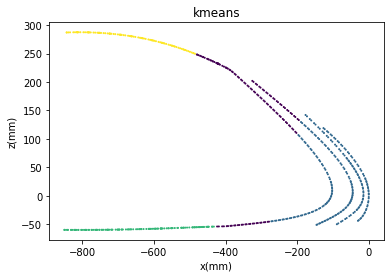

In [24]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data1)
y_kmeans_pred = kmeans.predict(data1)

# 画图查看分类效果
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=1, c=y_kmeans_pred)
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
plt.title('kmeans')

<font size=3>kmeans没有分出来4条曲线!</font>

##### <font size=3>Agg层次聚类效果：4种方法都尝试一下（'single', 'complete', 'average', 'ward'）</font>

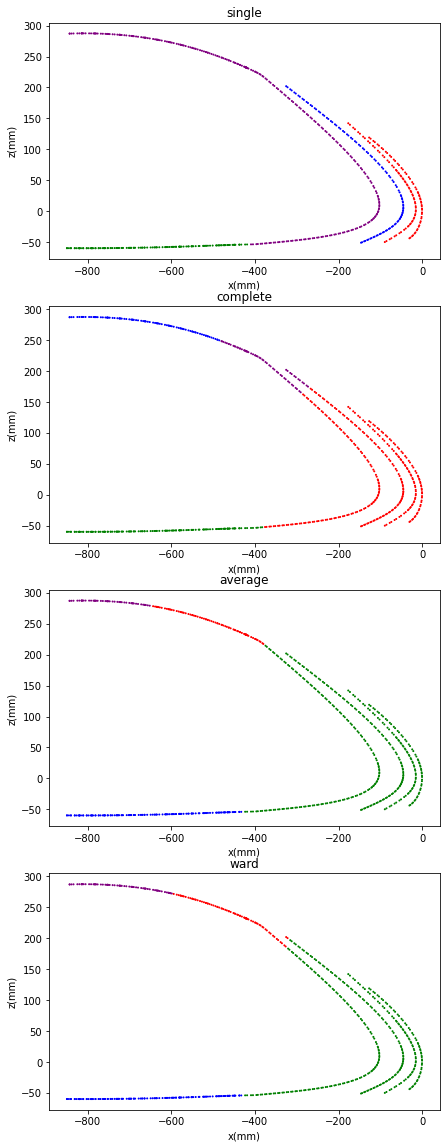

In [34]:
plt.figure(figsize=(7, 5*4))
colors = ListedColormap(["green", "red", "blue", "purple"])  # 设置不同类的颜色
i = 1
for algorithm in ['single', 'complete', 'average', 'ward']:
    plt.subplot(4, 1, i)  # 子视图
    model = AgglomerativeClustering(n_clusters=4, linkage=algorithm)
    model.fit(data1)
    y_agg_pred = model.labels_
    
    plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=1, c=y_agg_pred, cmap=colors)
    plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
    plt.title(algorithm)
    i += 1

<font size=3>没有分出来4条曲线!</font>

#### <font size=4>尝试用OVR的分类思想：将4分类问题变成3次二分类问题</font>

<font size=3>分析：观察发现，single方法分类效果优于其他三个，因此这里考虑用single linkage</font>

In [38]:
# single linkage模型
model = AgglomerativeClustering(n_clusters=2, linkage='single')

##### <font size=3>第一次二分类</font>

Text(0.5, 1.0, '第一次分类')

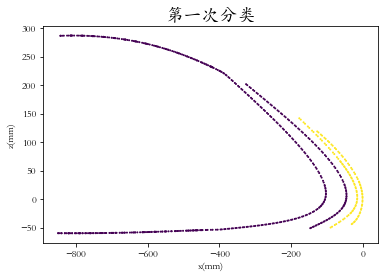

In [44]:
model.fit(data1)
y_pred1 = model.labels_

# 画图查看分类效果
plt.rcParams['font.family']='STKaiti'
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=1, c=y_pred1)
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
plt.title('第一次分类', fontsize=18)

Text(0.5, 1.0, 'x1')

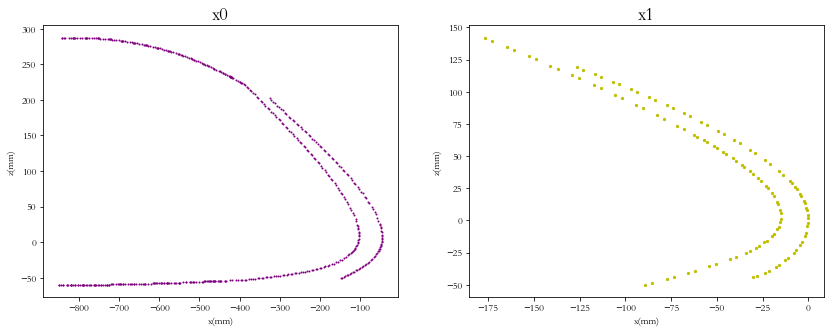

In [53]:
x0 = data1[y_pred1==0]
x1 = data1[y_pred1==1]

# 画x0、x1
plt.figure(figsize=(7*2, 5))

plt.subplot(1, 2, 1)  # 子视图
plt.scatter(x0.iloc[:, 0], x0.iloc[:, 1], s=1, c='purple')
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
plt.title('x0', fontsize=18)

plt.subplot(1, 2, 2)  # 子视图
plt.scatter(x1.iloc[:, 0], x1.iloc[:, 1], s=5, c='y')
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
plt.title('x1', fontsize=18)

##### <font size=3>第二次二分类：对x0作二分类</font>

Text(0.5, 1.0, '第二次分类')

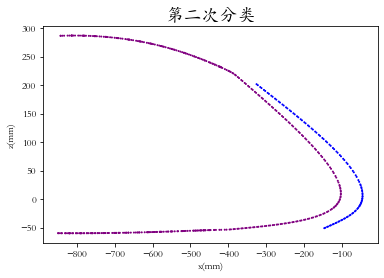

In [56]:
model.fit(x0)
y_pred2 = model.labels_

# 画图查看分类效果
colors = ListedColormap(["purple", "blue"])
plt.rcParams['font.family']='STKaiti'
plt.scatter(x0.iloc[:, 0], x0.iloc[:, 1], s=1, c=y_pred2, cmap=colors)
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
plt.title('第二次分类', fontsize=18)

<font size=3>最左侧两条曲线分类成功！</font>

##### <font size=3>第三次二分类：对x1作二分类</font>

Text(0.5, 1.0, '第三次分类')

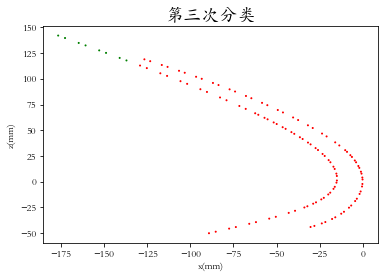

In [58]:
model.fit(x1)
y_pred3 = model.labels_

# 画图查看分类效果
colors = ListedColormap(["green", "red"])
plt.rcParams['font.family']='STKaiti'
plt.scatter(x1.iloc[:, 0], x1.iloc[:, 1], s=1, c=y_pred3, cmap=colors)
plt.xlabel('x(mm)'), plt.ylabel('z(mm)')
plt.title('第三次分类', fontsize=18)

<font size=3>后面也尝试过用kmeans、Agg的其他分类方法、谱聚类，均未能将右侧的这两条曲线分类出来，希望老师能够提供解决思路！</font>